In [72]:
#Prepare document:
#use PDFMiner
#run from command line: pdf2txt.py -o NewTextFileName.txt -t text PDFName.pdf
#creates TXT file from PDF. still lots of whitespace

import re
import pandas as pd




In [409]:
def get_SCOTUS_words(case_num):
    #read lines from TXT file as list of strings
    #if type(case_num) != 'string':
    #    raise ValueError('case_num must be a string')
    url = 'C:/Users/bschroeder/Documents/DataScience/Transcripts/' + str(case_num) + '.txt'
    lines = [line.strip() for line in open(url)]
    #RegEx for empty string, whitespace, header, footer, jibberish text, or line/page number
    cleanup = re.compile('(^$|^Alderson|^OfficialÂ|^Official - Subject|^Â|^\x0c|^[0-9]{1,2}$)')
    #remove cleanup text
    lines[:] = [x for x in lines if not cleanup.match(x)]
    #correct for hyphens
    lines[:] = [x.replace('Â\xad','-') for x in lines]
    #replace double-spaces with single
    lines[:] = [x.replace('  ',' ') for x in lines]
    #RegEx for all speakers (Mr, Ms, Solicitor General, Chief Justice, Justice)
    reSpeaking = re.compile('^(MR\.|MS\.|GENERAL|CHIEF JUSTICE|JUSTICE).*:')
    #RegEx for all non-Justice (Mr, Ms, Solicitor General)
    reOrator = re.compile('^(MR\.|MS\.|GENERAL) {1,2}.*:')
    #RegEx for 
    #instantiate blanks
    Speakers = pd.DataFrame(index=[],columns = ['Side', 'Attorney', 'Speaker', 'Words'])
    newwords = ''
    speaker = ''
    attorney = ''
    side = ''
    sidex = ''
    #hard-code tricky cases
    tricky = {'16-499':'NEITHER','15-1485':'PETITIONER','15-1493':'RESPONDENT','16-1276':'RESPONDENT','16-111':'PETITIONER',
             '16-980':'PETITIONER','16-1348':'RESPONDENT','17-43':'RESPONDENT','16-1466':'PETITIONER','17-21':'RESPONDENT',
             '16-1140':'NEITHER','17-387':'PETITIONER','16-1011':'PETITIONER','17-494':'PETITIONER','16-1215':'RESPONDENT',
             '17-130':'RESPONDENT','16-1220':'RESPONDENT'}
    x = 0
    #if line begins with speaker, append the previous statement with the previous Speaker
    #otherwise continue to add to the statement
    for i in lines:
        if i[:10] == '(Whereupon':
            break
        if reSpeaking.match(i):
            if x > 0:
                NewLine = pd.DataFrame(data=[[side,attorney,speaker,newwords]],index=[x],
                                       columns=['Side', 'Attorney','Speaker', 'Words'])
                Speakers = Speakers.append(NewLine)
            x += 1
            speaker = i.split(':')[0].strip()
            newwords = i.split(':')[1].strip()
            #print(speaker,newwords)   #troubleshooting
            if reOrator.match(i):
                if speaker != attorney:
                    attorney = speaker
        else:
            newwords += ' '
            newwords += i
        #if a new orator is encountered, change the Side
        #if (i.split('THE')[0] == 'ON BEHALF OF ')|(i.split('THE')[0] == 'SUPPORTING '): 
        if(i[:10] == 'ON BEHALF ')|(i[:10] == 'IN SUPPORT'):
            sidex = i.split('OF ')[1]
            if(sidex[:3] == 'THE'):
                sidex = sidex.split(' ')[1]
            if sidex[:4]=='RESP':
                side='RESPONDENT'
            elif sidex[:4]=='PETI':
                side='PETITIONER'
            elif sidex[:8]=='APPELLEE':
                side='RESPONDENT'
            elif sidex[:9]=='APPELLANT':
                side='PETITIONER'
            elif sidex[:11]=='POTTAWATOMI':
                side='RESPONDENT'
            elif sidex[:7]=='FEDERAL':
                side='RESPONDENT'
            elif sidex[:5]=='STATE':
                side='RESPONDENT'
            elif sidex[:7]=='PRIVATE':
                side='RESPONDENT'
            else:
                side=tricky.get(case_num)
            attorney = ''
        elif(i[:10] == 'SUPPORTING'):
            sidex = i.split('TING ')[1]
            if(sidex[:3] == 'THE'):
                sidex = sidex.split(' ')[1]            
            if sidex[:4]=='RESP':
                side='RESPONDENT'
            elif sidex[:4]=='PETI':
                side='PETITIONER'
            elif sidex[:8]=='APPELLEE':
                side='RESPONDENT'
            elif sidex[:9]=='APPELLANT':
                side='PETITIONER'
            else:
                side=tricky.get(case_num)
            attorney = ''
        if i[:20] == 'ACTING AS RESPONDENT':
            side = 'RESPONDENT'
            attorney = ''
    #add Length of each statement
    length = []
    for i in Speakers.index:
        length.append(len(Speakers.iloc[i-1].Words))
    Speakers['Length'] = length
    return Speakers;

In [410]:
acase = get_SCOTUS_words('16-6855')

In [411]:
acase[acase['Speaker']=='CHIEF JUSTICE ROBERTS']

,Side,Attorney,Speaker,Words,Length
1,PETITIONER,,CHIEF JUSTICE ROBERTS,"We'll hear argument next in Case 16-6855, Wils...",135
25,PETITIONER,MR. OLIVE,CHIEF JUSTICE ROBERTS,"I'm sorry, I lost -- what -- what's correct?",44
43,PETITIONER,MR. OLIVE,CHIEF JUSTICE ROBERTS,"Well, but if you have it -- I think in Foster ...",324
59,PETITIONER,MR. OLIVE,CHIEF JUSTICE ROBERTS,"Well, I thought the logic -- the logic would b...",399
109,RESPONDENT,,CHIEF JUSTICE ROBERTS,"Thank you, counsel. Ms. Warren. Heritage Repor...",137
168,RESPONDENT,MS. WARREN,CHIEF JUSTICE ROBERTS,What do you do when you're presenting an argum...,258
198,PETITIONER,,CHIEF JUSTICE ROBERTS,"Thank you, counsel. Three minutes, Mr. Olive. ...",108
216,PETITIONER,MR. OLIVE,CHIEF JUSTICE ROBERTS,"Well, since --",14
218,PETITIONER,MR. OLIVE,CHIEF JUSTICE ROBERTS,I would least -- at least like to give you the...,83


In [354]:
def get_SCOTUS_details(case_num):
    #get words list via function
    CaseSpeakers = get_SCOTUS_words(case_num)
    #get stats per speaker for petitioner side
    pRoberts = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'CHIEF JUSTICE ROBERTS')].Length.sum()
    pKennedy = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KENNEDY')].Length.sum()
    pThomas = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE THOMAS')].Length.sum()
    pGinsburg = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GINSBURG')].Length.sum()
    pBreyer = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE BREYER')].Length.sum()
    pAlito = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE ALITO')].Length.sum()
    pSotomayor = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE SOTOMAYOR')].Length.sum()
    pKagan = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KAGAN')].Length.sum()
    pGorsuch = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GORSUCH')].Length.sum()
    petitioner = CaseSpeakers[(CaseSpeakers['Side'] == 'PETITIONER') & 
                        (CaseSpeakers['Speaker'] != 'CHIEF JUSTICE ROBERTS') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE KENNEDY') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE THOMAS') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GINSBURG') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE BREYER') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE ALITO') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE SOTOMAYOR') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE KAGAN') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GORSUCH')].Length.sum()
    #get stats per speaker for respondent side
    rRoberts = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'CHIEF JUSTICE ROBERTS')].Length.sum()
    rKennedy = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KENNEDY')].Length.sum()
    rThomas = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE THOMAS')].Length.sum()
    rGinsburg = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GINSBURG')].Length.sum()
    rBreyer = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE BREYER')].Length.sum()
    rAlito = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE ALITO')].Length.sum()
    rSotomayor = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE SOTOMAYOR')].Length.sum()
    rKagan = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE KAGAN')].Length.sum()
    rGorsuch = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] == 'JUSTICE GORSUCH')].Length.sum()
    respondent = CaseSpeakers[(CaseSpeakers['Side'] == 'RESPONDENT') & 
                        (CaseSpeakers['Speaker'] != 'CHIEF JUSTICE ROBERTS') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE KENNEDY') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE THOMAS') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GINSBURG') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE BREYER') &
                         (CaseSpeakers['Speaker'] != 'JUSTICE ALITO') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE SOTOMAYOR') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE KAGAN') & 
                         (CaseSpeakers['Speaker'] != 'JUSTICE GORSUCH')].Length.sum()
    #combine into list and transform to dataframe
    casedetails = [[case, pRoberts, pKennedy, pThomas, pGinsburg, pBreyer,
                                 pAlito, pSotomayor, pKagan, pGorsuch, petitioner,
                                 rRoberts, rKennedy, rThomas, rGinsburg, rBreyer,
                                 rAlito, rSotomayor, rKagan, rGorsuch, respondent]]
    CaseSummary = pd.DataFrame(data=casedetails, columns=['Case',
                                'P Roberts', 'P Kennedy', 'P Thomas', 'P Ginsburg', 'P Breyer', 
                                'P Alito', 'P Sotomayor', 'P Kagan', 'P Gorsuch', 'Petitioner',
                                'R Roberts', 'R Kennedy', 'R Thomas', 'R Ginsburg', 'R Breyer', 
                                'R Alito', 'R Sotomayor', 'R Kagan', 'R Gorsuch', 'Respondent'])
    return CaseSummary;

In [366]:
#ignoring case '15-1039' because it refers to both sides as petitioner; original cases as well; 16-1495 AND 7-2 because dismissed 
cases = ['16-399','16-605','16-373','16-529','16-349','15-577','16-240','16-5294','16-6219','16-466','16-405','16-309',
        '16-499','16-299','16-658','16-424','15-1485','15-1204','16-1161','16-285','15-1498','16-6795','16-6855',
         '15-1509','16-460','16-784','16-498','16-712','16-969','15-1439','16-1276','16-402','16-476','16-534','16-111','16-1067',
         '16-1144','16-1371','16-1027','16-980','16-1150','16-961','16-1362','16-8255','16-1348',
         '16-9493','17-43','16-1466','16-1454','17-21','16-1435','16-1432','16-1140','17-387','17-312','17-432',
         '17-155','17-5716','17-333','17-530','16-1011','17-494','16-1215','16-1519','17-269','17-130','17-459','17-5639',
         '17-586','16-1220','17-965']


In [567]:
get_SCOTUS_details('15-1204')

,Case,P Roberts,P Kennedy,P Thomas,P Ginsburg,P Breyer,P Alito,P Sotomayor,P Kagan,P Gorsuch,...,R Roberts,R Kennedy,R Thomas,R Ginsburg,R Breyer,R Alito,R Sotomayor,R Kagan,R Gorsuch,Respondent
0,17-965,541,1383,0,264,3736,526,2872,2213,0,...,3165,17,0,846,1656,1103,581,931,1919,25134


In [412]:
Summary = pd.DataFrame(columns=['Case',
                                'P Roberts', 'P Kennedy', 'P Thomas', 'P Ginsburg', 'P Breyer', 
                                'P Alito', 'P Sotomayor', 'P Kagan', 'P Gorsuch', 'Petitioner',
                                'R Roberts', 'R Kennedy', 'R Thomas', 'R Ginsburg', 'R Breyer', 
                                'R Alito', 'R Sotomayor', 'R Kagan', 'R Gorsuch', 'Respondent'])

for case in cases:
    Summary = Summary.append(get_SCOTUS_details(case))

In [413]:
Summary.reset_index(inplace=True,drop=True)

In [414]:
Summary

,Case,P Roberts,P Kennedy,P Thomas,P Ginsburg,P Breyer,P Alito,P Sotomayor,P Kagan,P Gorsuch,...,R Roberts,R Kennedy,R Thomas,R Ginsburg,R Breyer,R Alito,R Sotomayor,R Kagan,R Gorsuch,Respondent
0,16-399,1044,407,0,1085,0,889,1579,517,2549,...,3551,0,0,376,2241,847,1201,4844,1789,20473
1,16-605,1463,1019,0,1367,1710,788,1411,1465,808,...,3739,1141,0,247,2701,841,1237,0,2412,17758
2,16-373,602,896,0,38,2225,891,919,306,820,...,1265,90,0,1628,1154,0,1777,3174,0,21823
3,16-529,666,807,0,1390,0,991,2531,347,340,...,3690,1016,0,690,3052,320,1107,1737,849,21394
4,16-349,1406,0,0,794,3055,2387,0,903,0,...,394,0,0,1256,675,0,842,593,0,25574
5,15-577,913,1525,0,1398,1156,1035,3003,3895,0,...,1912,323,0,0,3836,3144,879,2659,1126,14644
6,16-240,2695,0,0,849,848,2718,2230,657,2279,...,1432,756,0,278,3505,1036,869,3292,0,17513
7,16-5294,2505,2021,0,889,1036,2689,2247,1123,1130,...,113,971,0,1859,3427,819,274,4782,421,14742
8,16-6219,3567,1057,0,751,3009,2872,1648,0,2845,...,403,725,0,627,3646,303,2080,5622,0,13579
9,16-466,478,1360,0,1588,1352,94,3577,2882,443,...,2395,542,0,1475,2633,98,195,2803,1380,20303


In [401]:
file='SCOTUS2.csv'

In [416]:
Summary.to_csv(file)

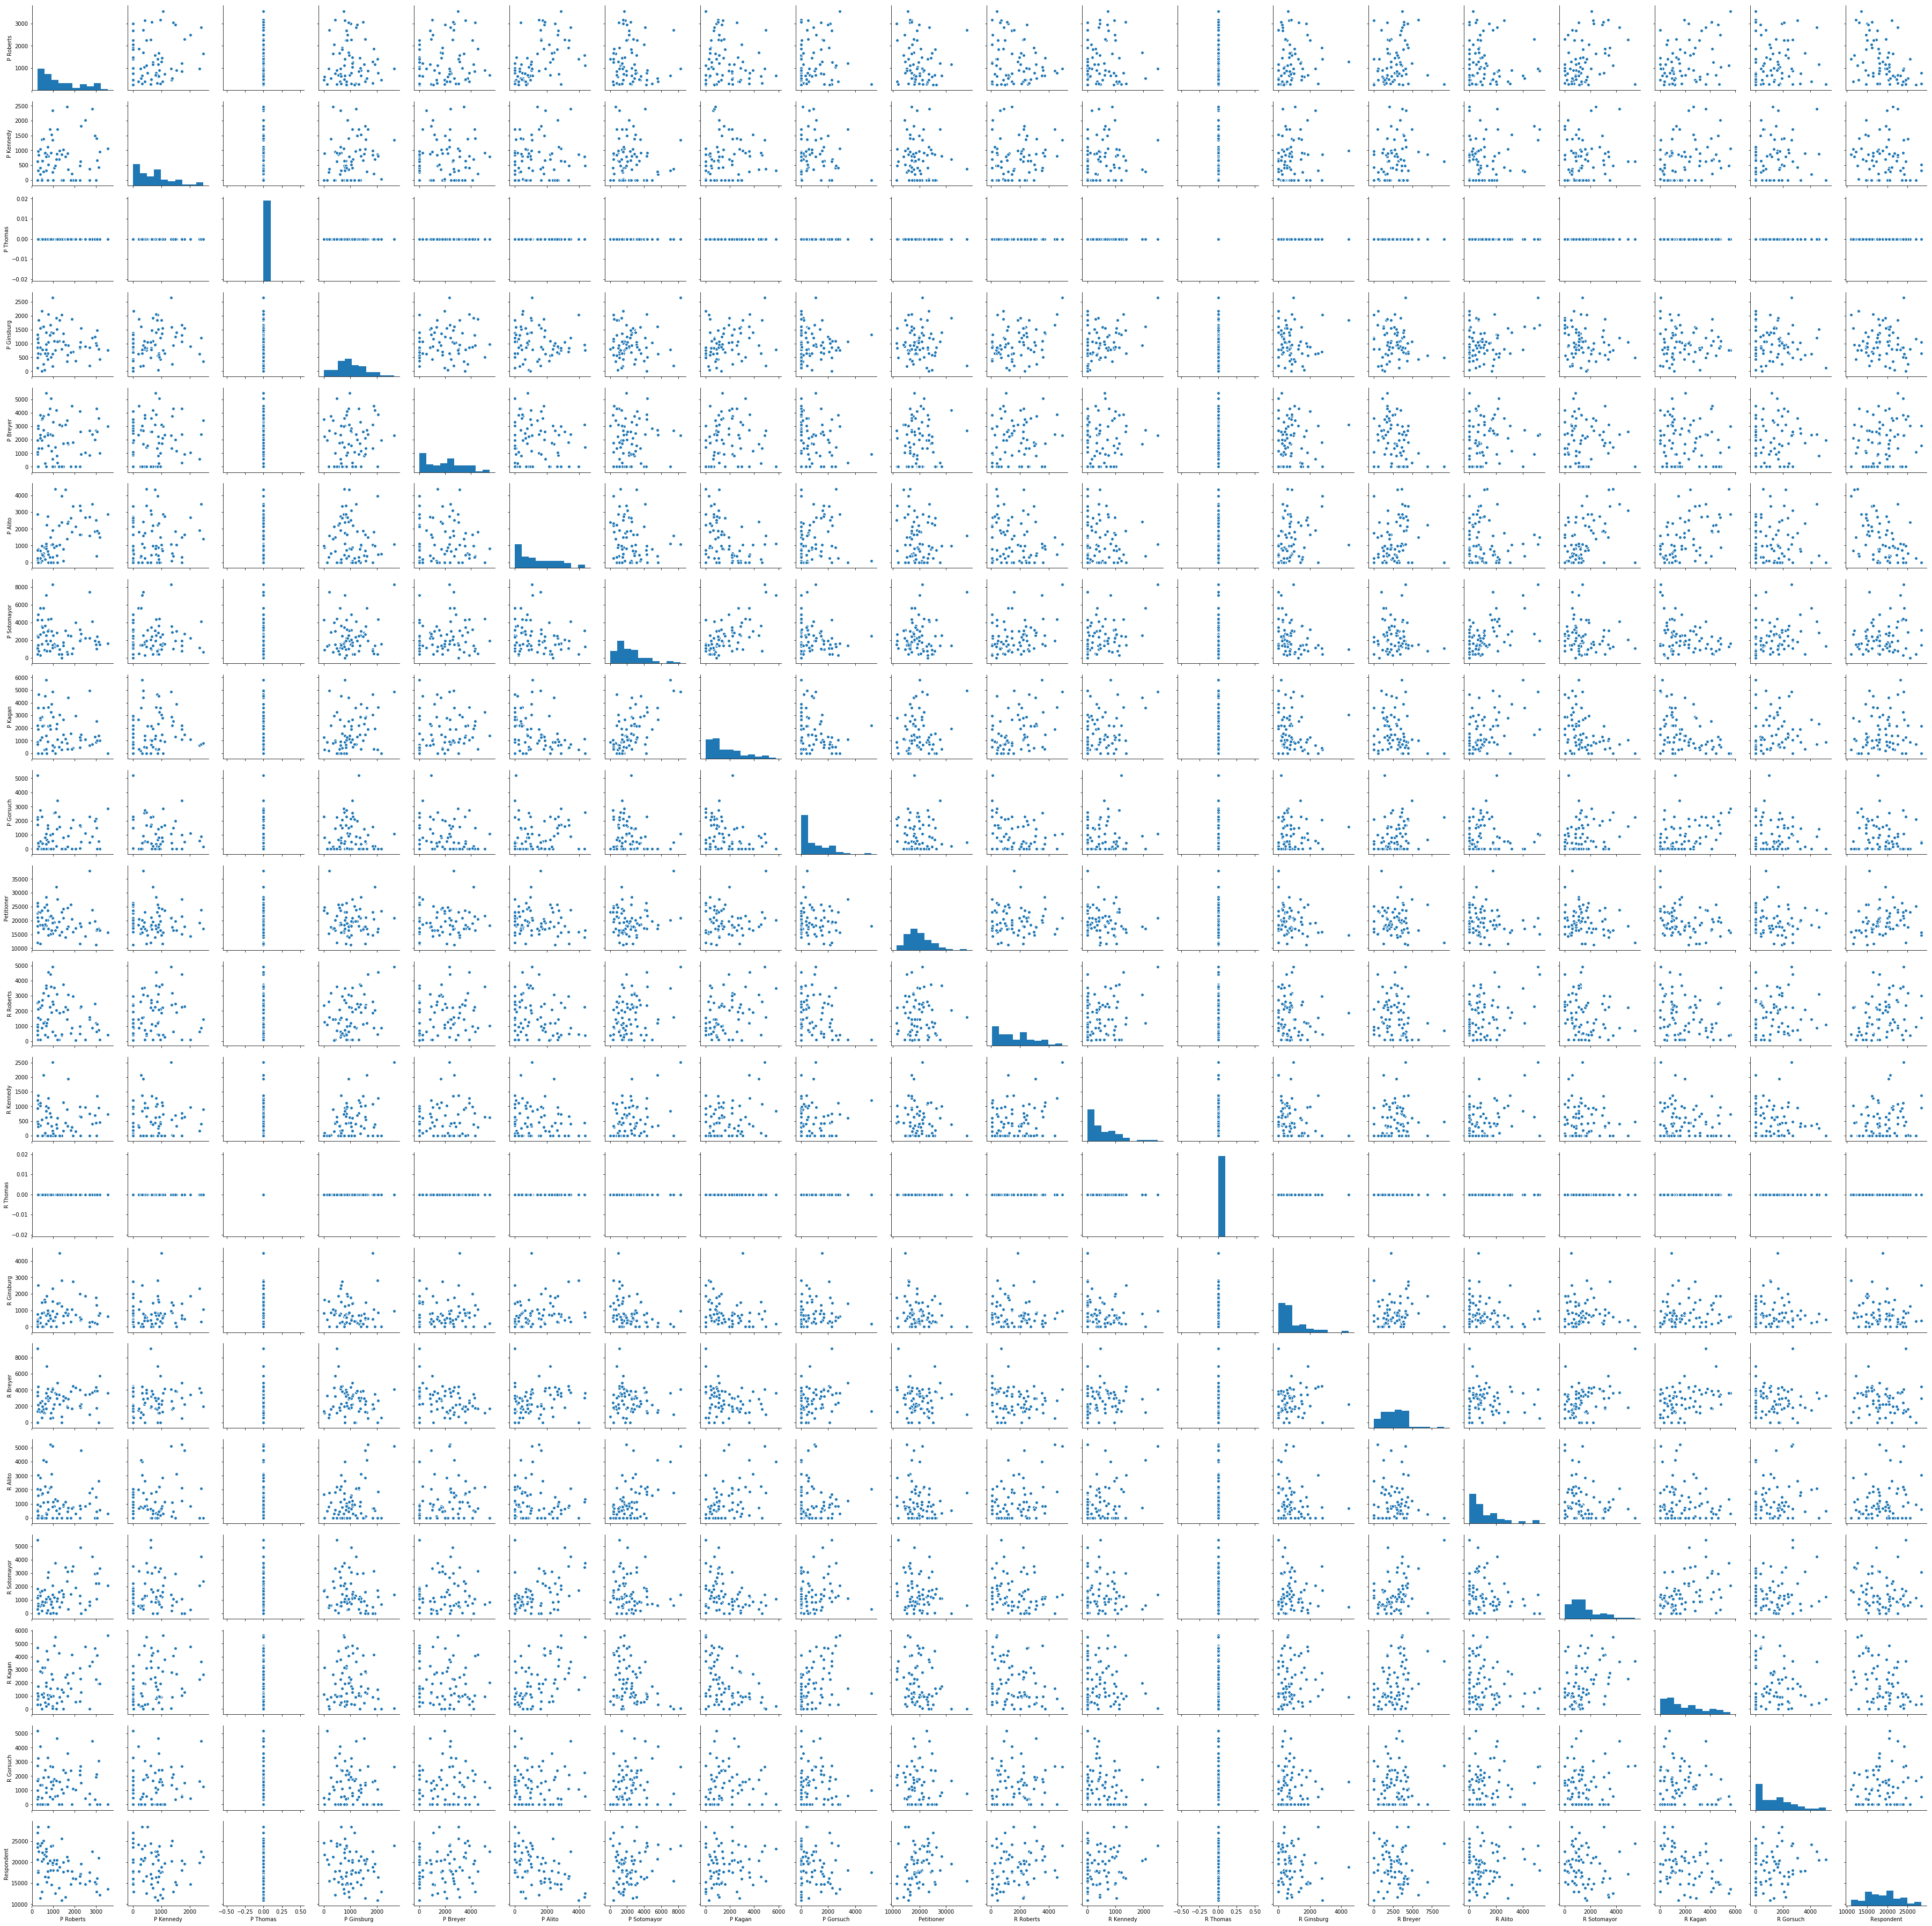

In [417]:
sns.pairplot(Summary)

## Modeling

In [434]:
CasesSum = pd.read_excel('Cases.xlsx')

In [435]:
Votes = CasesSum[['Roberts Vote', 'Kennedy Vote', 'Thomas Vote', 'Ginsburg Vote', 'Breyer Vote',
                 'Alito Vote', 'Sotomayor Vote', 'Kagan Vote', 'Gorsuch Vote']]

In [436]:
Votes = Votes.replace({'P':1,'R':0})

In [437]:
Wording = CasesSum[['P Roberts', 'P Kennedy', 'P Ginsburg', 'P Breyer', 'P Alito', 'P Sotomayor', 'P Kagan', 'P Gorsuch',
                   'Arg Roberts','Arg Kennedy','Arg Ginsburg','Arg Breyer','Arg Alito','Arg Sotomayor','Arg Kagan','Arg Gorsuch']]

In [438]:
VotesLater = Votes[Votes['Roberts Vote'].isnull()]

In [441]:
WordingLater = Wording[Votes['Roberts Vote'].isnull()]

In [442]:
VotesNow = Votes[Votes['Roberts Vote'].isnull()==False]

In [443]:
WordingNow = Wording[Votes['Roberts Vote'].isnull()==False]

In [557]:
y= VotesNow['Roberts Vote']

In [558]:
X_train, X_test, y_train, y_test = train_test_split(WordingNow, y)

In [559]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [560]:
pred = lr.predict(X_test)

In [561]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

        0.0       1.00      0.33      0.50         3
        1.0       0.82      1.00      0.90         9

avg / total       0.86      0.83      0.80        12



In [562]:
print(confusion_matrix(y_test,pred))

[[1 2]
 [0 9]]


In [563]:
print(lr.coef_)

[[-1.52975672  0.81392522 -0.15628117 -0.69760455 -0.80109052  0.25485254
   0.28200445 -0.65123972  0.75358638  0.26899908  0.79217945 -0.23398085
   0.22600981 -0.29844171  0.08037269  0.7111117 ]]


In [566]:
print(np.std(X_train,0))

P Roberts        0.269985
P Kennedy        0.354389
P Ginsburg       0.222134
P Breyer         0.275020
P Alito          0.305509
P Sotomayor      0.267309
P Kagan          0.289073
P Gorsuch        0.339149
Arg Roberts      0.431194
Arg Kennedy      0.535437
Arg Ginsburg     0.593636
Arg Breyer       0.330275
Arg Alito        0.571253
Arg Sotomayor    0.418759
Arg Kagan        0.400889
Arg Gorsuch      0.676462
dtype: float64


In [481]:
import numpy as np

In [467]:
from sklearn.linear_model import LogisticRegression

In [469]:
lr = LogisticRegression()

In [470]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [471]:
pred = lr.predict(X_test)

In [473]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

        0.0       0.62      0.71      0.67         7
        1.0       0.50      0.40      0.44         5

avg / total       0.57      0.58      0.57        12



In [218]:
CasesSum

,Number,Roberts Vote,Kennedy Vote,Thomas Vote,Ginsburg Vote,Breyer Vote,Alito Vote,Sotomayor Vote,Kagan Vote,Gorsuch Vote,...,R Roberts,R Kennedy,R Thomas,R Ginsburg,R Breyer,R Alito,R Sotomayor,R Kagan,R Gorsuch,Respondent
0,16-399,1,1,0,1,1,1,1,1,0,...,3562,0,0,377,2251,852,1207,4860,1802,20502
1,16-605,1,1,1,1,1,1,1,1,1,...,3755,1144,0,250,2705,846,1243,0,2425,17627
2,16-373,0,0,0,1,1,0,1,1,0,...,1268,91,0,1634,1154,0,1791,3180,0,21720
3,16-529,1,1,1,1,1,1,1,1,1,...,3709,1025,0,694,3072,321,1115,1744,858,21370
4,16-349,0,0,0,0,0,0,0,0,0,...,396,0,0,1257,675,0,846,594,0,25512
5,15-577,1,1,1,0,1,1,0,1,1,...,1924,325,0,0,3849,3154,884,2666,1130,14621
6,16-240,0,0,0,0,1,0,0,1,0,...,1440,758,0,279,3511,1042,872,3301,0,17537
7,16-5294,0,1,0,1,1,0,1,1,0,...,115,973,0,1867,3443,821,277,4791,423,14754
8,16-6219,0,0,0,1,1,0,1,1,0,...,408,727,0,628,3657,304,2088,5636,0,13542
9,16-466,1,1,1,1,1,1,0,1,1,...,2339,552,0,1484,2645,100,198,2815,1386,20326


In [221]:
import sklearn

In [223]:
from sklearn.ensemble import RandomForestClassifier

In [224]:
X = CasesSum.drop('Roberts Vote', axis=1)

In [225]:
X = X.drop('Number', axis=1)

In [243]:
X = X.drop('Kennedy Vote', axis=1)

In [244]:
X = X.drop('Thomas Vote', axis=1)
X = X.drop('Ginsburg Vote', axis=1)
X = X.drop('Breyer Vote', axis=1)
X = X.drop('Alito Vote', axis=1)
X = X.drop('Sotomayor Vote', axis=1)
X = X.drop('Kagan Vote', axis=1)
X = X.drop('Gorsuch Vote', axis=1)

In [226]:
rf = RandomForestClassifier()

In [227]:
y = CasesSum['Roberts Vote']

In [230]:
from sklearn.model_selection import train_test_split

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [246]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [247]:
pred = rf.predict(X_test)

In [235]:
from sklearn.metrics import confusion_matrix, classification_report

In [248]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.67      1.00      0.80         2

avg / total       0.44      0.67      0.53         3



C:\Users\bschroeder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [237]:
rf.feature_importances_

array([0.     , 0.2375 , 0.1    , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.1    , 0.     , 0.     , 0.     , 0.20625, 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.1    , 0.     , 0.     ,
       0.05625, 0.1    , 0.1    , 0.     , 0.     , 0.     , 0.     ])

In [239]:
a=0
features = []
imp = []
for i in X_train.columns:
    features.append(i)
    imp.append(rf.feature_importances_[a])
    a += 1

feats = pd.DataFrame({'Feature':features, 'Importance':imp})

sort_feats = feats.sort_values(by='Importance', ascending=False)

for i in sort_feats.index:
    print('{:2f}'.format(sort_feats['Importance'][i]), sort_feats['Feature'][i])

0.237500 Thomas Vote
0.206250 P Breyer
0.100000 R Alito
0.100000 R Breyer
0.100000 P Roberts
0.100000 R Roberts
0.100000 Ginsburg Vote
0.056250 R Ginsburg
0.000000 Kennedy Vote
0.000000 P Gorsuch
0.000000 R Gorsuch
0.000000 R Kagan
0.000000 R Sotomayor
0.000000 R Thomas
0.000000 R Kennedy
0.000000 Petitioner
0.000000 P Sotomayor
0.000000 P Kagan
0.000000 P Alito
0.000000 P Ginsburg
0.000000 P Thomas
0.000000 P Kennedy
0.000000 Gorsuch Vote
0.000000 Kagan Vote
0.000000 Sotomayor Vote
0.000000 Alito Vote
0.000000 Breyer Vote
0.000000 Respondent


In [240]:
corr_mat = CasesSum.corr()

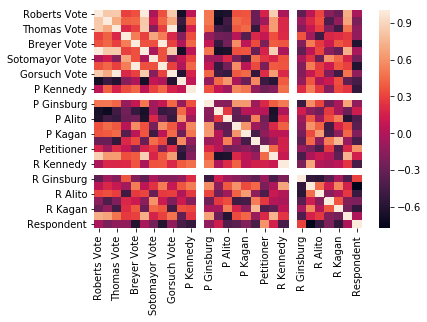

In [241]:
sns.heatmap(corr_mat)

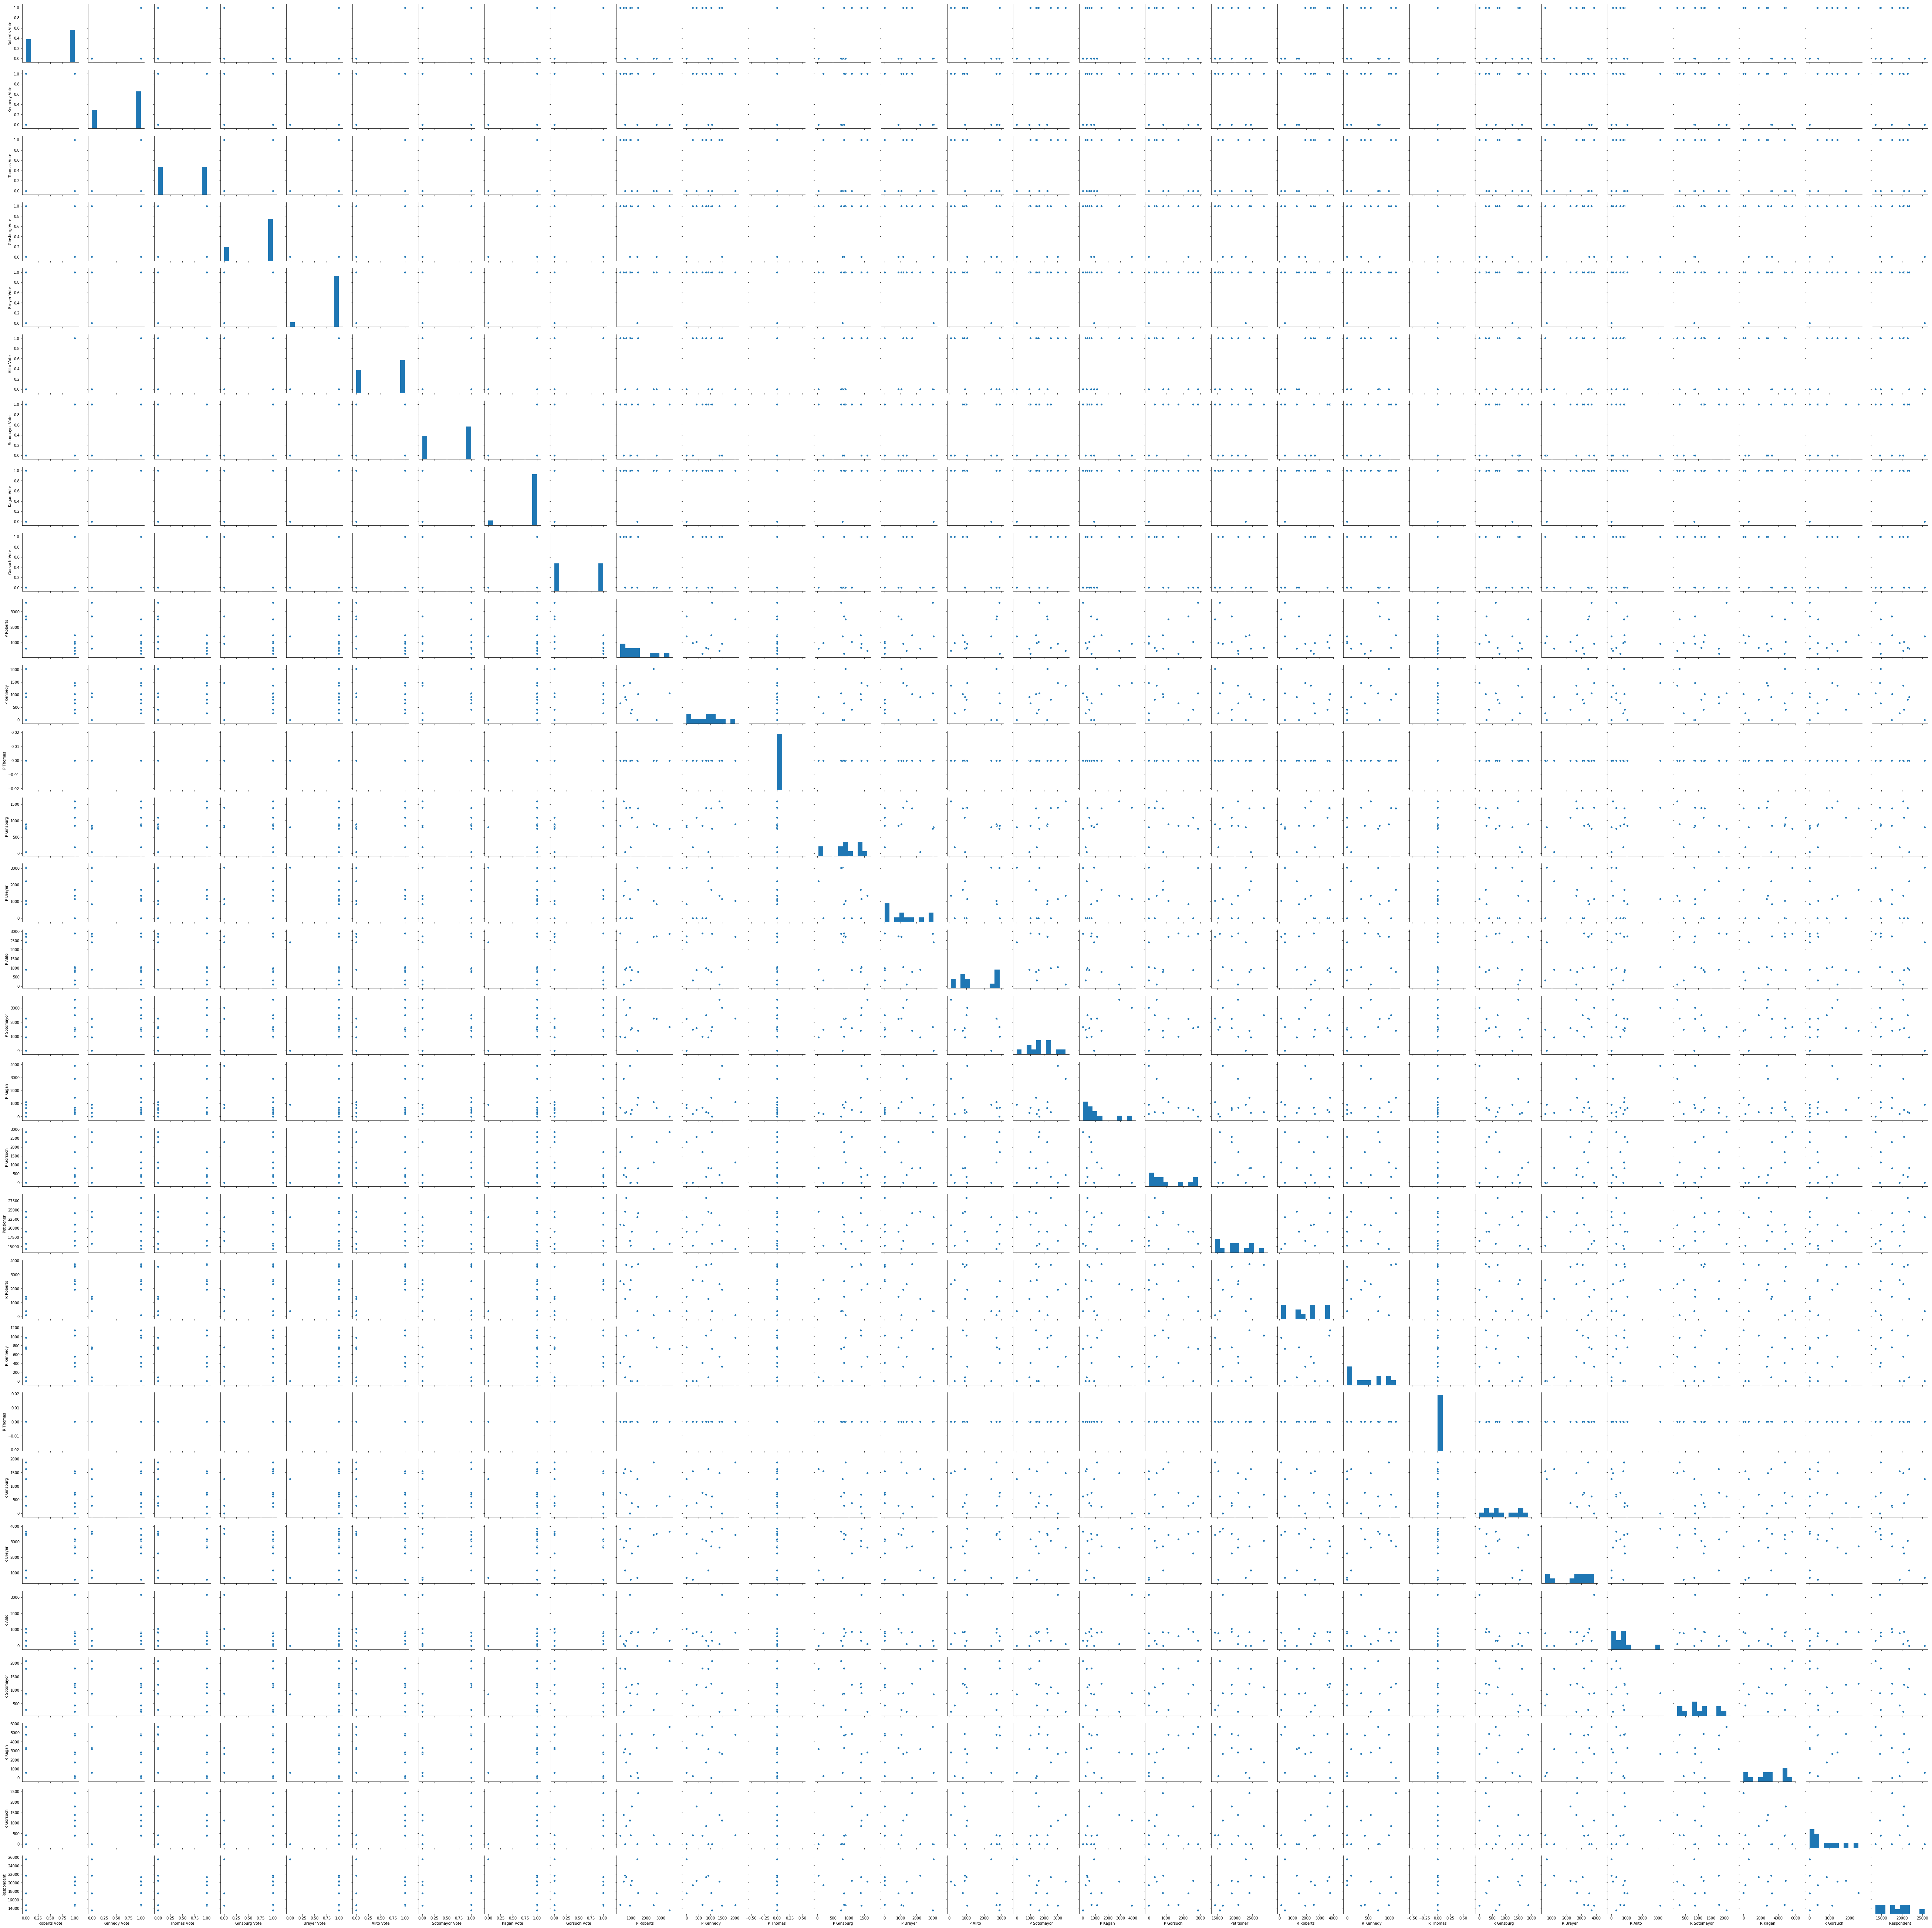

In [242]:
sns.pairplot(CasesSum)

## Plotting

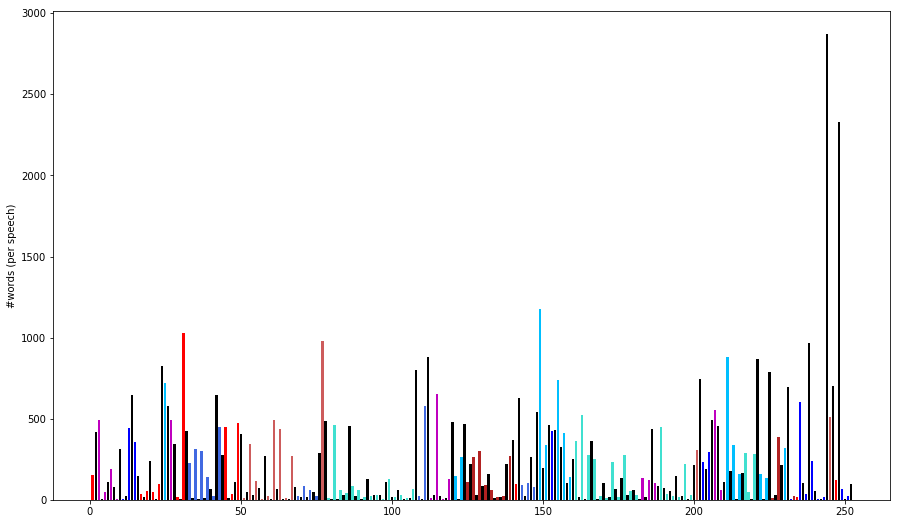

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

speakers = get_SCOTUS_words(cases[7])

#color-code Justices
speakers['color'] = speakers['Speaker'].map({'CHIEF JUSTICE ROBERTS': 'r',
                                             'JUSTICE KENNEDY': 'm','JUSTICE ALITO': 'indianred','JUSTICE GORSUCH': 'firebrick',
                                            'JUSTICE GINSBURG': 'b','JUSTICE BREYER': 'turquoise','JUSTICE SOTOMAYOR': 'royalblue',
                                            'JUSTICE KAGAN': 'deepskyblue'})
#fill remaining (attorneys) as black
speakers['color'].fillna('k', inplace=True)

plt.figure(num=1, figsize=(15, 9));
ax = plt.bar(x=speakers.index,height=speakers.Length,color=speakers.color);
plt.ylabel('#words (per speech)');